In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from PIL import Image
import scipy.fftpack as sfft
import scipy
import math
import scipy.ndimage
%config InlineBackend.figure_format='retina'

In [229]:
N = M = 100
g = np.zeros((M, M))
#g[50:70, 50:90] = 1
#g[10:80, 20:25] = 1
g[40, :] = 1
g[80, :] = 1
g[:, 30] = 1


y = px + t
x = ry + e

r = 1/p
e = -t/p

In [231]:
np.savetxt("input.csv", g.astype(np.uint8), delimiter = ',', fmt='%d')

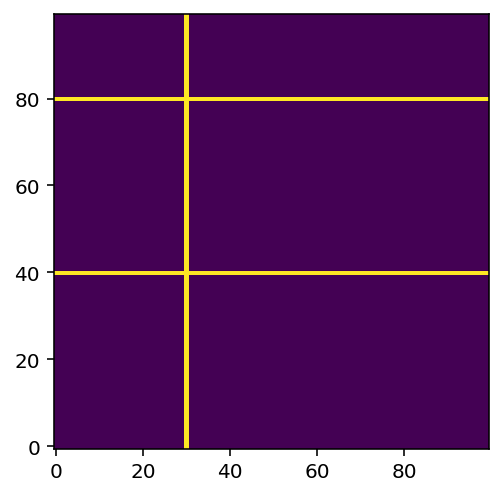

In [226]:
plt.imshow(g, origin = "lower")

In [205]:
H = 200
K = 100
x_min, dx = 0, 1
y_min, dy = 0, 1
tau_min, dtau = -100, 1
alphas = np.linspace(-np.pi/4, np.pi/4, K)
p = np.tan(alphas)

In [207]:
def radon(g, p, H, K):
    M, N = g.shape
    g_radon = np.zeros(shape = (K, H))
    plot = np.zeros(shape = (M, N))
    x_min = -M//2
    y_min = -M//2
    for k in range(K):
        tau = np.linspace(-M//2, M//2, H) / np.sin(np.pi/2 - alphas[k])
        for h in range(H):
            beta = (p[k]*x_min+tau[h]-y_min)/dy
            alpha = p[k] * dx / dy
            s = 0
            for m in range(M):
                n = int(np.round(alpha*m+beta))
                if n >= 0 and n < N:
                    s += g[m, n]
                    plot[m, n] = k
            g_radon[k, h] = dx * s
    return g_radon, plot

In [233]:
g_radon, _ = radon(g, p, H, K)

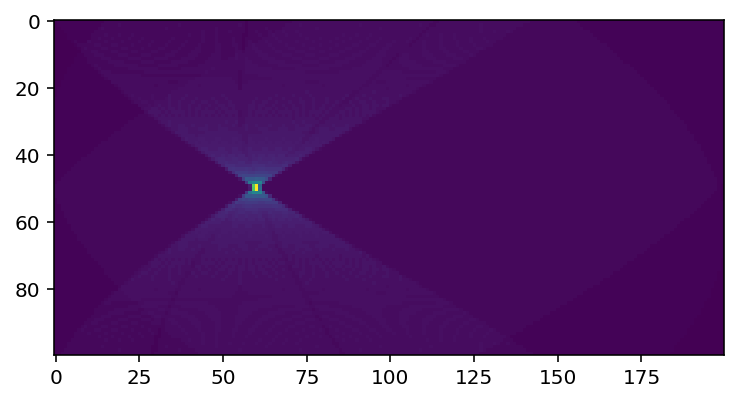

In [246]:
plt.imshow(g_radon)

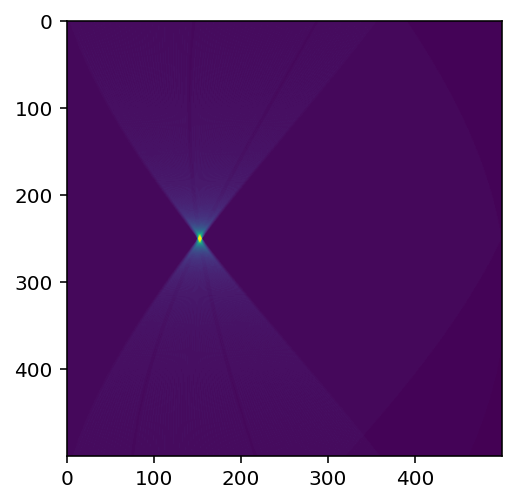

In [248]:
rust_g_radon = np.loadtxt("rust_output.csv", delimiter = ",")
plt.imshow(rust_g_radon)

In [208]:
g_radon_fill = radon(g.T, p, H, K)[0]

Text(0, 0.5, 'y')

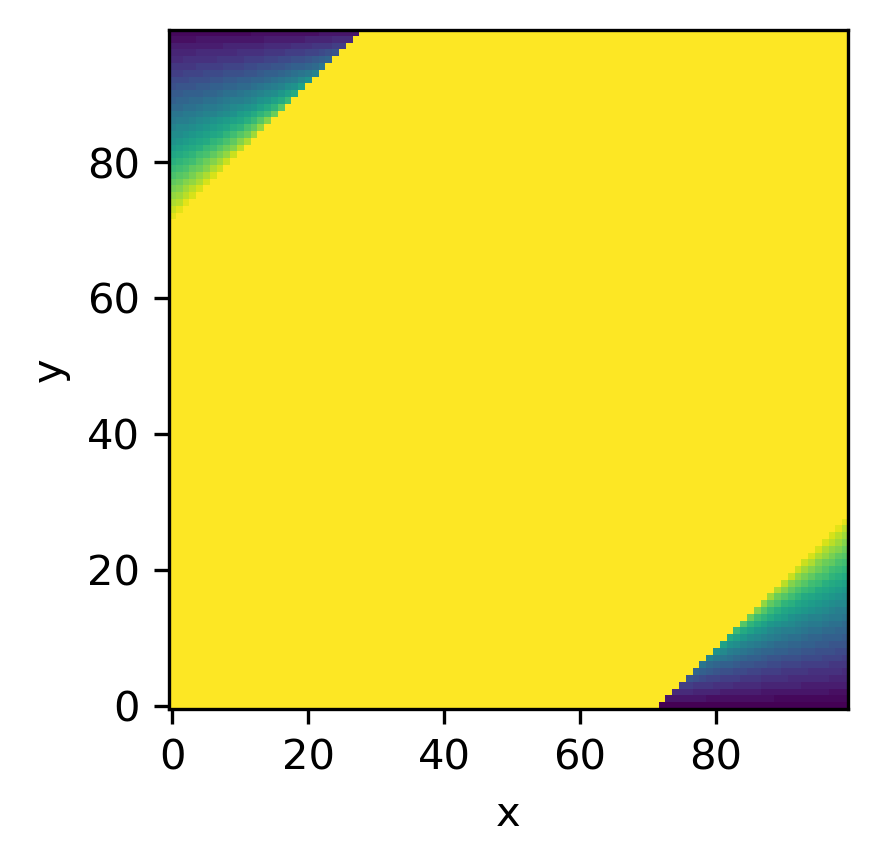

In [216]:
plt.figure(dpi=150, figsize = (3, 3))
plt.imshow(plot.T, interpolation = "nearest", origin = "lower")
plt.xlabel("x"); plt.ylabel("y")

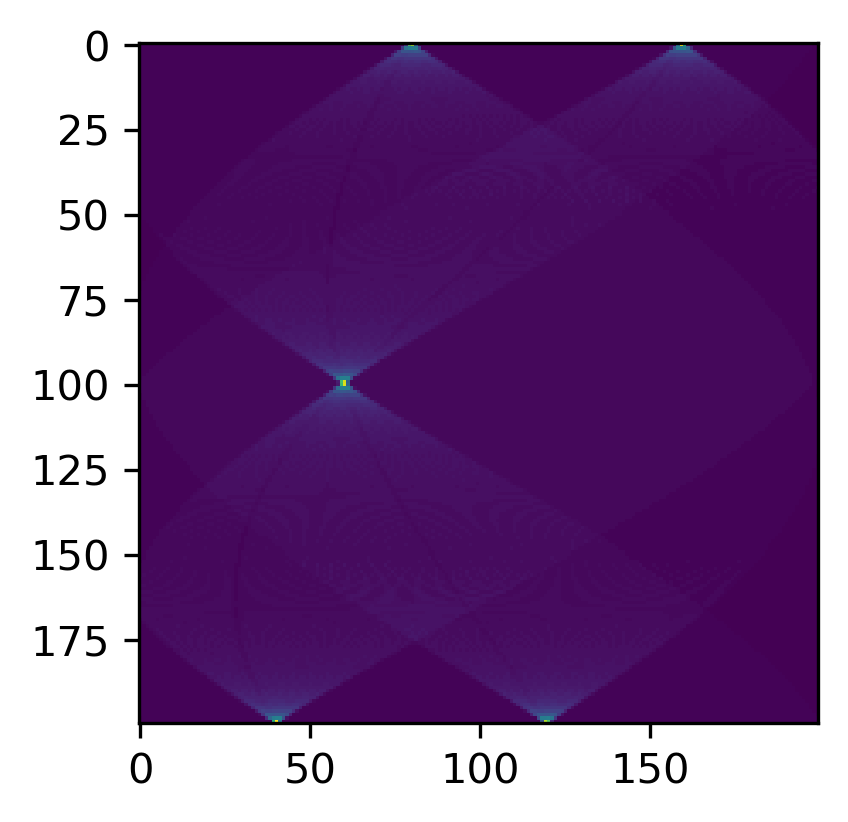

In [210]:
plt.figure(dpi=150, figsize = (3, 3))
reconstruct = np.vstack([np.flip(g_radon_fill[0:K//2, :], axis = 0), g_radon, np.flip(np.flip(g_radon_fill[K//2:K, :], axis = 0), axis = 1)])
plt.imshow(reconstruct)

In [211]:
projection_fft = np.fft.fftshift(
    np.fft.fft(
        np.fft.fftshift(reconstruct), 
        axis = 1))

In [212]:
alphas_recon = np.linspace(-np.pi/2, np.pi/2, 200)
x_norm, y_norm = np.linspace(-0.5, 0.5, reconstruct.shape[0]), np.zeros(reconstruct.shape[1])

x_rotate = x_norm[:, None] * np.cos(alphas_recon[None, :]) - y_norm[:, None] * np.sin(alphas_recon[None, :])
y_rotate = x_norm[:, None] * np.sin(alphas_recon[None, :]) + y_norm[:, None] * np.cos(alphas_recon[None, :])

x_flat = x_rotate.ravel()
y_flat = y_rotate.ravel()
projection_flat = reconstruct.ravel(order='F')
projection_fft_flat = projection_fft.ravel(order='F')

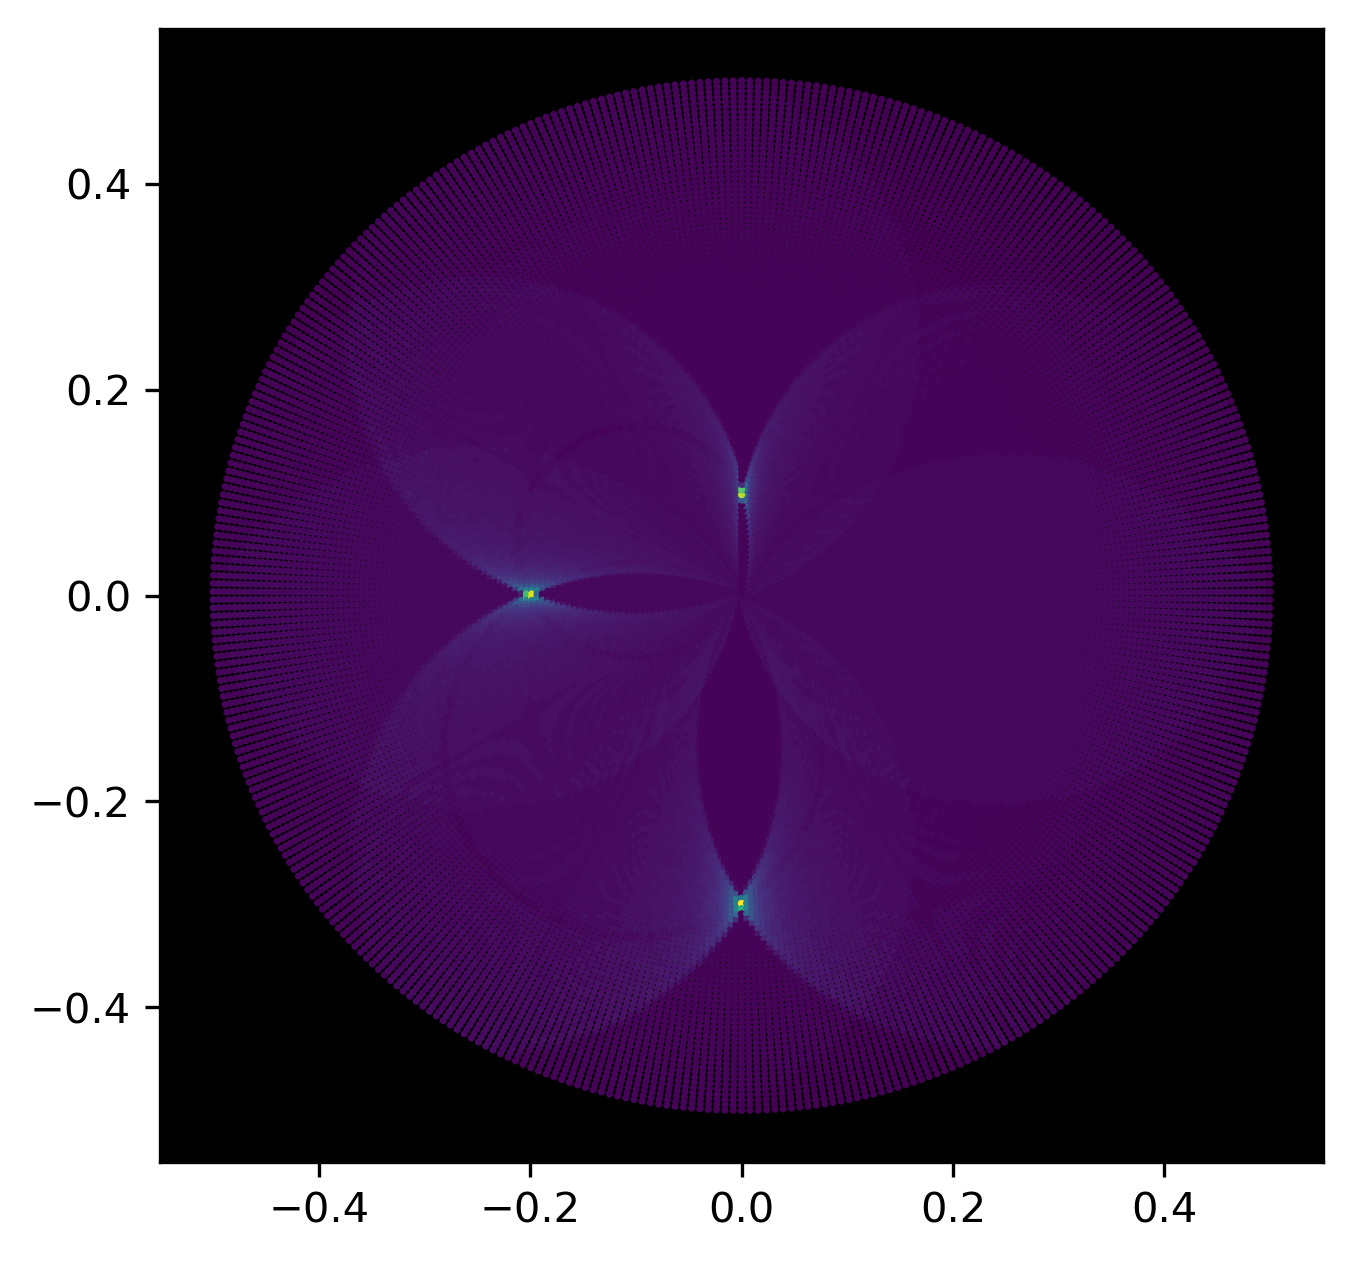

In [213]:
plt.figure(figsize = (5, 5), dpi = 150)
ax = plt.gca()
ax.set_facecolor('black')
plt.scatter(x_flat, y_flat, c = projection_flat, s = 0.5)

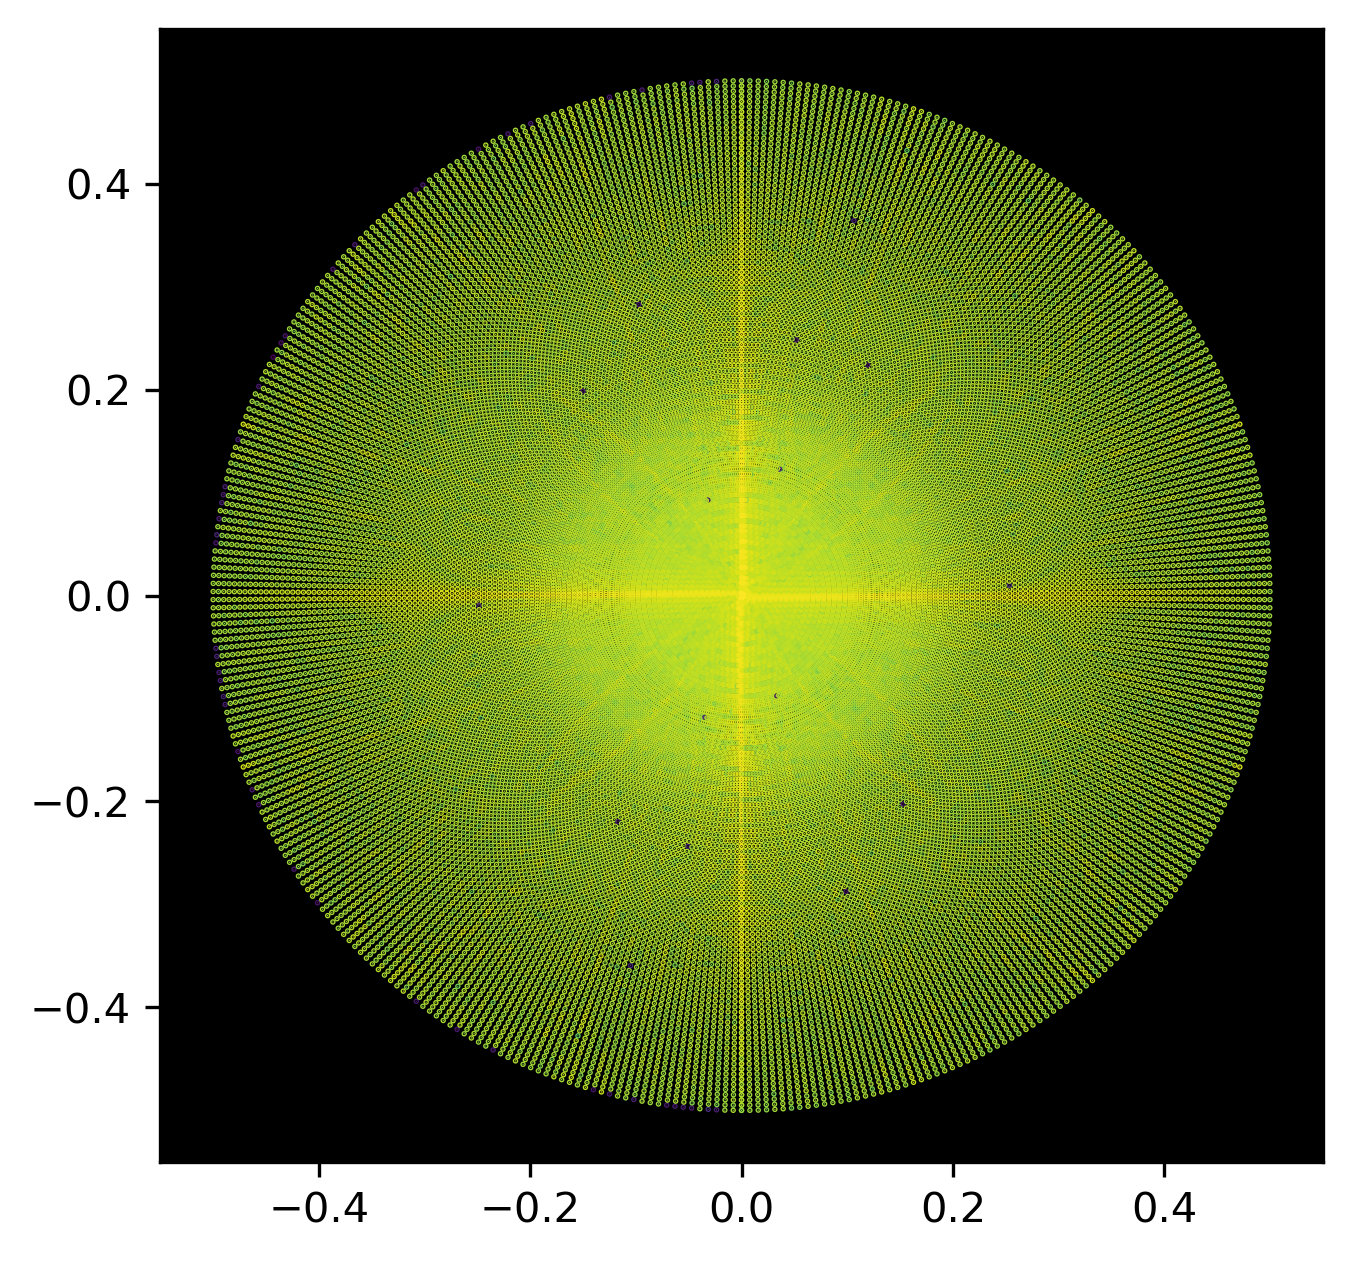

In [105]:
plt.figure(figsize = (5, 5), dpi = 150)
ax = plt.gca()
ax.set_facecolor('black')
plt.scatter(x_flat, y_flat, c = np.log10(np.abs(projection_fft_flat)), s = 0.1, alpha = 1)

In [118]:
interp_size = 200
x_interp, y_interp = np.linspace(-0.5, 0.5, interp_size), np.linspace(-0.5, 0.5, interp_size)
X_interp, Y_interp = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_flat, y_flat), projection_fft_flat, (X_interp.flatten(), Y_interp.flatten()), method='linear')
z_interp = np.reshape(z_interp, (interp_size, interp_size))
z_interp[np.isnan(z_interp)] = 0
z_interp_shift = sfft.fftshift(z_interp)

/var/folders/y4/k9nckdyx5mx6rt8nd7n0r2_r0000gn/T/ipykernel_16650/3939038813.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(np.abs(z_interp)))


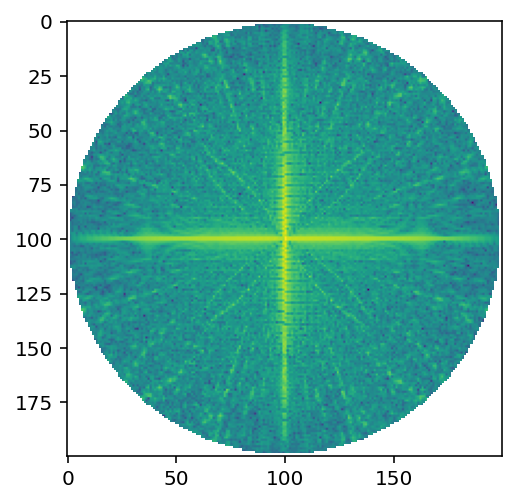

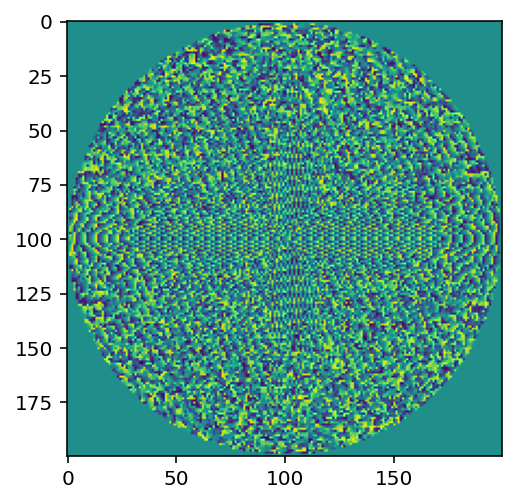

In [119]:
plt.figure()
plt.imshow(10*np.log10(np.abs(z_interp)))
plt.figure()
plt.imshow(np.angle(z_interp))

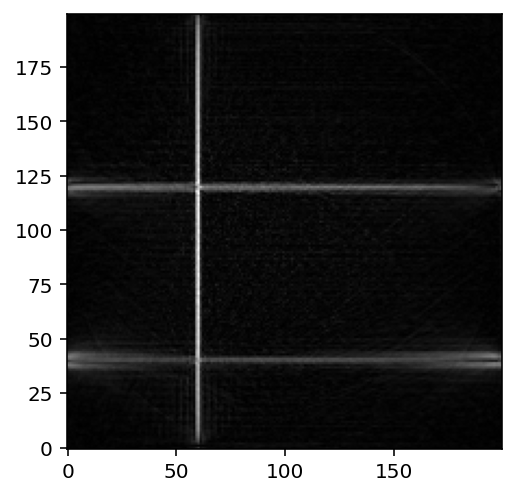

In [120]:
image_recon = np.fft.fftshift(sfft.ifft2(z_interp_shift))
plt.imshow(np.abs(image_recon), cmap = 'gray', origin = "lower")